In [1]:
from mermin_benchmarking import *

In [2]:
from qiskit import __version__
print(__version__)

1.4.0


In [3]:
num_qubits = 3

### circuit_generation.py

- Obtener términos y coeficientes: `mermin_terms`, `simplified_mermin_terms`
- Tipos de circuitos:
    - `mermin_circuits`
    - `mermin_aspect_circuit`
    - `modified_mermin_aspect_circuit`

In [4]:
terms, coeffs = mermin_terms(num_qubits)
print(terms, coeffs)

['XXY', 'XYX', 'YXX', 'YYY'] [1.0, 1.0, 1.0, -1.0]


In [5]:
simplified_mermin_terms(num_qubits)

(['XXY', 'YYY'], [3.0, -1.0])

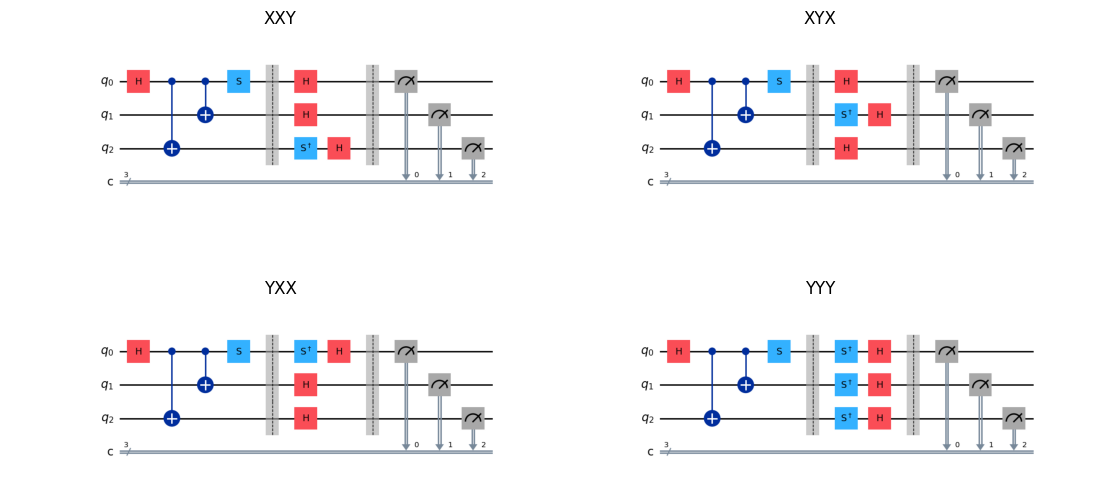

In [6]:
draw_circuits(mermin_circuits(terms), terms)

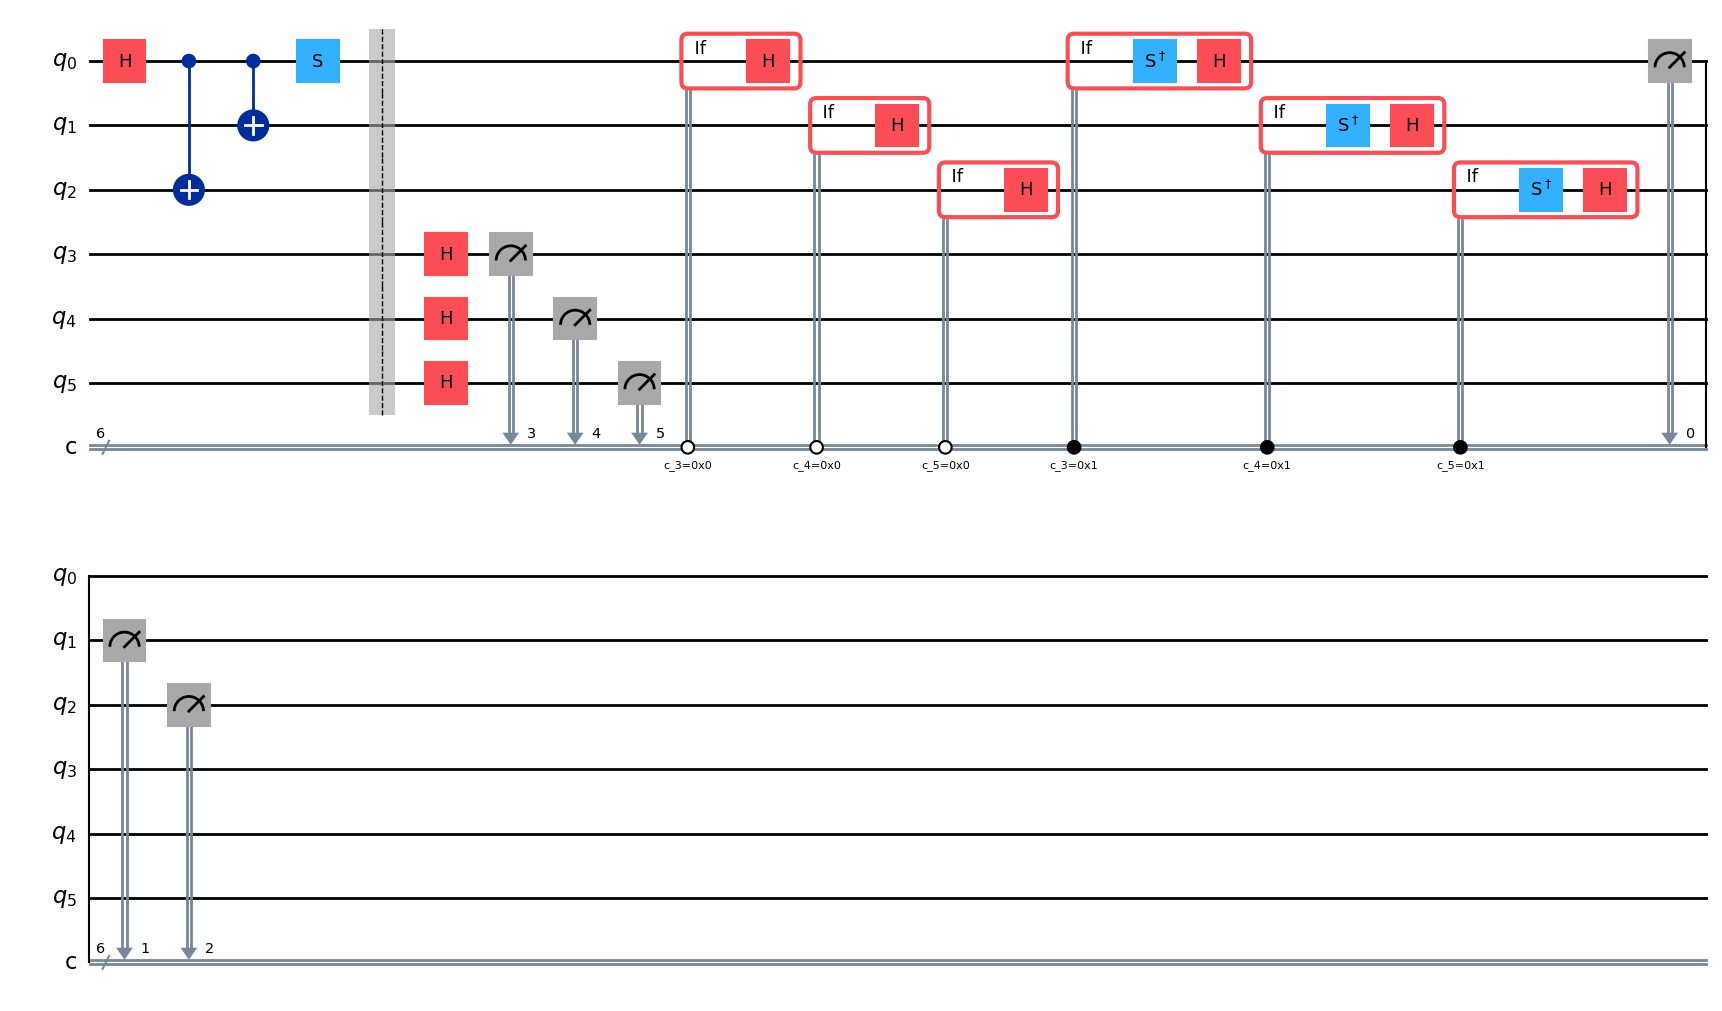

In [7]:
draw_circuits(mermin_aspect_circuit(num_qubits))

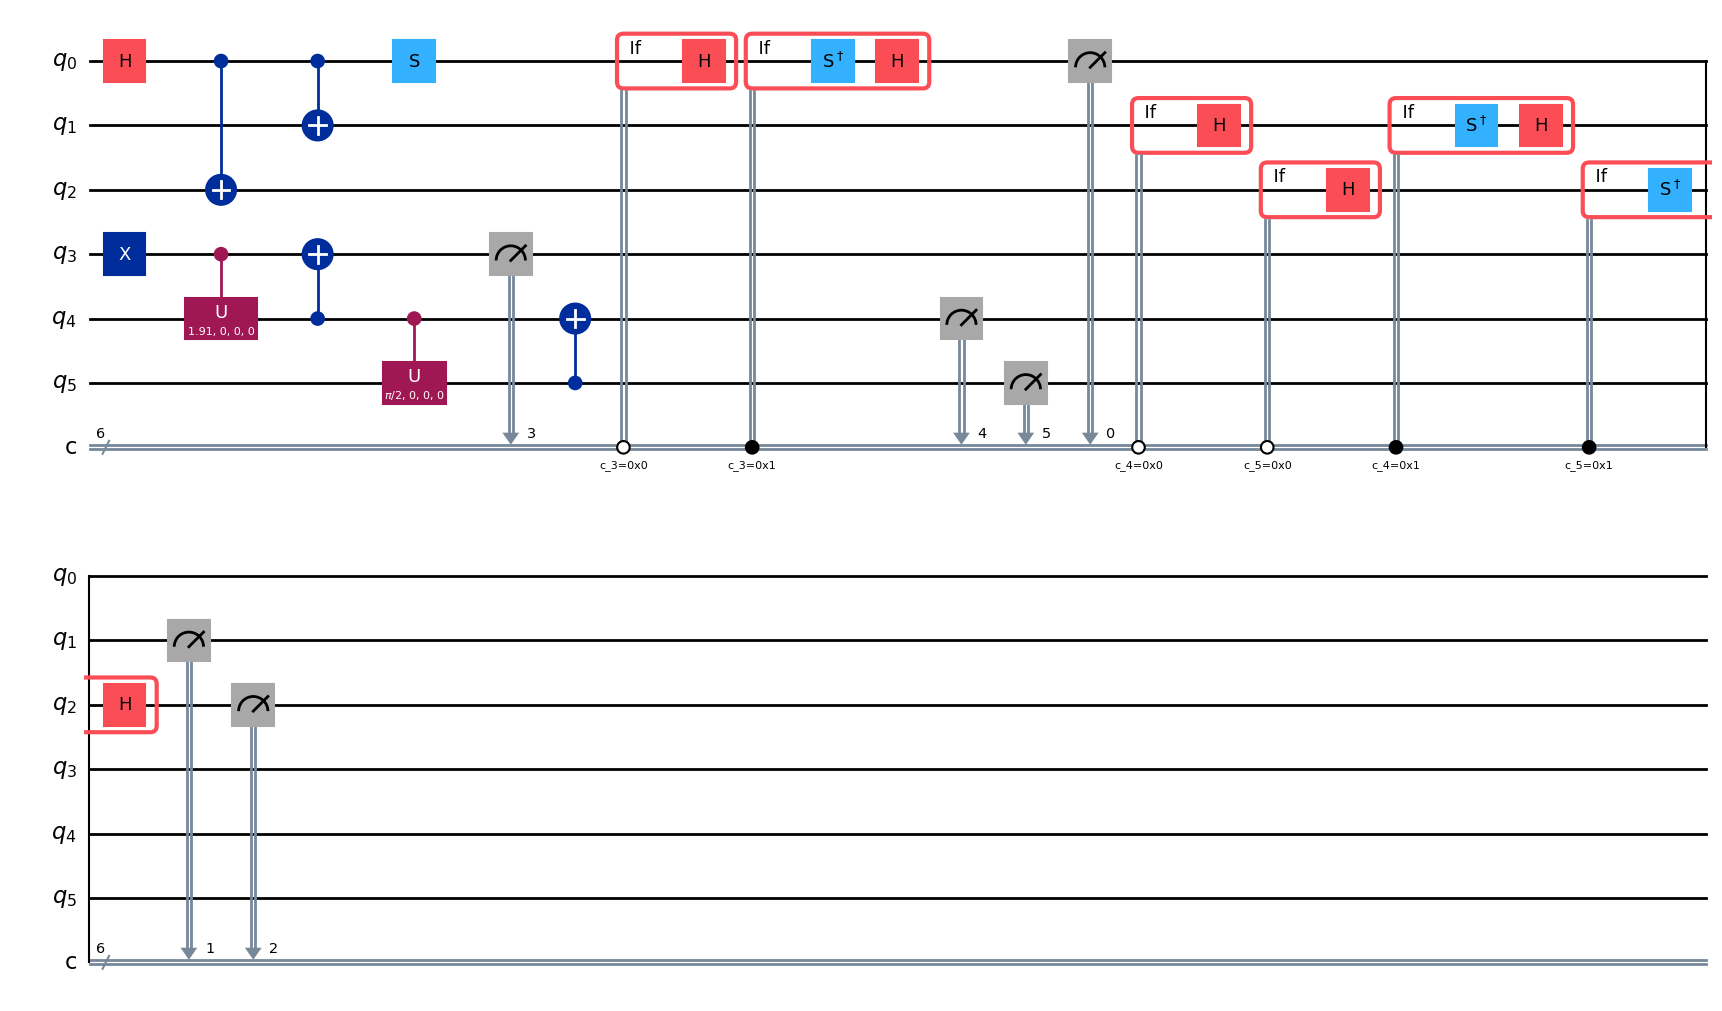

In [8]:
draw_circuits(modified_mermin_aspect_circuit(num_qubits))

### ghz_optimization.py

- Obtener qubits físicos: `get_physical_qubits`, `get_aux_physical_qubits` (qubits ancilla para variante Aspect)
- Estado GHZ: `GHZ_state`
- Estado W: `W_state`

In [9]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke, FakePrague

In [10]:
backend = FakePrague()
physical_qubits = get_physical_qubits(num_qubits, backend)
aux_qubits = get_aux_physical_qubits(num_qubits, backend, physical_qubits)
print('Mejores qubits considerando el error de medida y el de las puertas de dos qubits.')
print(f'Qubits principales: {physical_qubits}, qubits ancilla: {aux_qubits}')

Mejores qubits considerando el error de medida y el de las puertas de dos qubits.
Qubits principales: [4, 6, 7], qubits ancilla: [19, 22, 25]


--- Creación estado GHZ ---
Sin backend


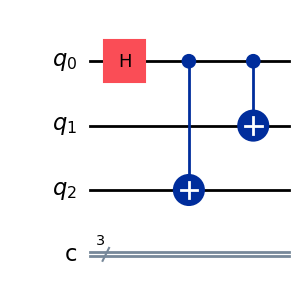

Con fake_prague


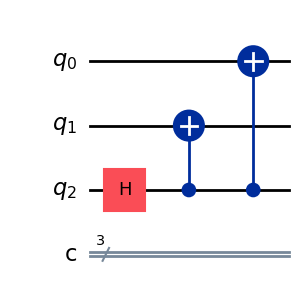

In [11]:
print('--- Creación estado GHZ ---')
print('Sin backend')
display(GHZ_state(num_qubits).draw())
print(f'Con {backend.name}')
display(GHZ_state(num_qubits, backend, physical_qubits).draw())

--- Creación estado W ---
Sin backend


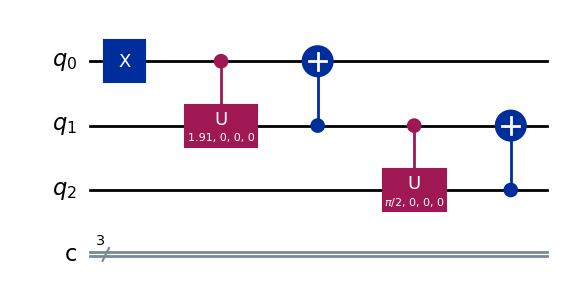

Implementación estado W teniendo en cuenta el layout no contemplada


In [12]:
print('--- Creación estado W ---')
print('Sin backend')
display(W_state(num_qubits).draw())
print('Implementación estado W teniendo en cuenta el layout no contemplada')

In [13]:
from qiskit.visualization import *
from qiskit_aer import AerSimulator

qc = W_state(num_qubits)
qc.save_statevector()

sim = AerSimulator()
result = sim.run(qc).result()
out_state = result.get_statevector()
array_to_latex(out_state, prefix="\\text{Statevector = }")
out_state.draw('latex')

<IPython.core.display.Latex object>

In [14]:
#from qiskit.visualization import plot_error_map
#plot_error_map(backend)

### measurement.py

- Experimento con circuitos para cada término del polinomio de Mermin: `run_static`
- Experimento con variante Aspect: `run_dynamic`

In [15]:
static_circuits = mermin_circuits(mermin_terms(num_qubits)[0], backend, physical_qubits)
print(f'Qubits físicos: {physical_qubits}')
run_static(static_circuits, shots=1024*2**5, backend=backend, physical_qubits=physical_qubits)

Qubits físicos: [4, 6, 7]


3.74322509765625

In [16]:
static_experiment = MerminExperiment(num_qubits, shots=1024*2**5, backend=backend, mode='static', error_mitigation=False)
print(static_experiment.run())
print(static_experiment.metrics)

3.75244140625
{'average_depth': 14.0, 'average_two_qubit_gates': 2.0, 'fidelity': 0.9681978465250941}


In [17]:
from qiskit.circuit.controlflow import IfElseOp
backend.target.add_instruction(IfElseOp, name='if_else')

In [18]:
dynamic_circuit = mermin_aspect_circuit(num_qubits, backend, physical_qubits)
dynamic_circuit_qubits = physical_qubits + get_aux_physical_qubits(num_qubits, backend, physical_qubits)
print(f'Qubits físicos: {dynamic_circuit_qubits}')

run_dynamic(dynamic_circuit, shots=1024*2**5, backend=backend, physical_qubits=dynamic_circuit_qubits)

Qubits físicos: [4, 6, 7, 19, 22, 25]


3.866455078125

In [19]:
dynamic_experiment = MerminExperiment(num_qubits, shots=1024*2**5, backend=backend, mode='dynamic', error_mitigation=False)
print(dynamic_experiment.run())
print(dynamic_experiment.metrics)

3.868408203125
{'average_depth': 16.0, 'average_two_qubit_gates': 2.0, 'fidelity': 0.9347915310921764}


In [20]:
# Mitigación a nivel hardware con dynamical decoupling y twirling (solo backends reales)

from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    SamplerV2 as Sampler,
    SamplerOptions
)
sampler_options = SamplerOptions()
sampler_options.default_shots = 5000
sampler_options.dynamical_decoupling.enable = True
sampler_options.dynamical_decoupling.sequence_type = 'XpXm'
sampler_options.twirling.enable_measure = True

In [21]:
static_experiment = MerminExperiment(num_qubits, shots=1024*2**5, backend=backend, mode='static', error_mitigation=False, sampler_options=sampler_options)
print(static_experiment.run())
print(static_experiment.metrics)

/home/arebla/anaconda3/envs/qiskit1.0/lib/python3.11/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:233: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XpXm'}, 'twirling': {'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


3.7481689453125
{'average_depth': 14.0, 'average_two_qubit_gates': 2.0, 'fidelity': 0.9681978465250941}
